In [1]:
#downloading datasets
import torchvision as thv
import numpy as np
train = thv.datasets.MNIST('../dat///////a' , download=True , train=True ) #training set
val = thv.datasets.MNIST('../data' , download=True , train=False ) #testing set
print(val.data.shape , len(train.targets) )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../dat///////a/MNIST/raw/train-images-idx3-ubyte.gz to ../dat///////a/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../dat///////a/MNIST/raw/train-labels-idx1-ubyte.gz to ../dat///////a/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../dat///////a/MNIST/raw/t10k-images-idx3-ubyte.gz to ../dat///////a/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../dat///////a/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../dat///////a/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([10000, 28, 28]) 60000


In [2]:
#selecting 50% of train and test sets to make new train and test data
train_indx = np.random.randint(low=0, high=60000, size=30000) #selecting 30000 training index
X_train = np.array(train.data[train_indx])
X_train = X_train.reshape(30000,-1) #flattening the image data
y_train = np.array(train.targets[train_indx])

val_indx = np.random.randint(low=0, high=10000, size=5000) #selecting 5000 test index
X_val = np.array(val.data[val_indx])
X_val = X_val.reshape(5000,-1) #flattening image data
y_val = np.array(val.targets[val_indx])

#normalizing pixel values 
X_train = X_train.astype(float) / 255
X_val = X_val.astype(float) / 255

In [52]:
class LinearLayer_t:
    def __init__(self):
        #initializing weights and biases
        self.weights = np.random.normal(0,0.01, size = (784,10))
        self.biases = np.random.normal(0,0.01, size = (1,10))
        #setting dw and db to zero
        self.grad_weights = np.array([])
        self.grad_biases = np.array([])
        
    def forward(self,x):

        self.x = x #saving input data for backward function
        linear_forward = np.dot(x,self.weights) + self.biases #linear transformation
        return linear_forward
    
    def backward(self,grad_output):
        # computing dL/dw = dz/dw*(previous layer backpropagation value)
        #dz/dw = x
        #grad output = dL/da*da/dz
        self.grad_weights = np.dot(self.x.T, grad_output)
        self.grad_biases = grad_output.mean(axis=0)*self.x.shape[0]

        #dL/dw and dL/db will be accessed from main function when computing SGD step
        return None
    
    def zero_grad(self):
        #setting all gradient values to 0
        self.grad_weights = self.grad_weights*0
        self.grad_biases = self.grad_biases*0
        return None
    

In [53]:
class Relu_t:
    def __init__(self):
        #no initialization
        pass
    
    def forward(self, input_vector):
        #applying a = max(0,z) transformation for reLU and saving a 
        #for backward function
        self.relu_forward = np.maximum(0,input_vector)
        return self.relu_forward
    
    def backward(self, grad_output):
        a = self.relu_forward  
        #grad output = dL/da
        #differentiation of reLU da/dz
        a[a>0] = 1
        a[a<0] = 0
        
        return grad_output*a #gradient value = dL/da*da/dz

In [54]:
class Softmax_Cross_Entropy_t:
    def __init__(self):
        pass
    
    #def Softmax(self,vector):
        #e = np.exp(vector)
       # return e / e.sum()
    #Cross Entropy Loss
   # def cross_entropy(self,actual,pred):
       # loss= -np.log(pred)
        #return loss
    

    def forward(self,z, yhat):
        
        self.softmax = np.exp(z) / np.exp(z).sum(axis=-1,keepdims=True) #softmax output is saved for backward function and predict function
        #taking prediction probability of only those y's that belong to corresponding targets
        y_pred_prob = z[np.arange(len(z)),yhat]
        #cross entropy loss
        entropy = - y_pred_prob + np.log(np.sum(np.exp(z),axis=-1))
        return entropy 
    
    def backward(self,yhat):

        #first creating array with zeros of the same shape as softmax output
        temp_array = np.zeros_like(self.softmax)
        #selecting only those elements in array whose index = target values 
        #and making them 1 while rest are 0
        temp_array[np.arange(len(self.softmax)),yhat] = 1
        #computing gradient at output layer dL/da
        return (- temp_array + self.softmax) / self.softmax.shape[0]
    
    def predict(self):
      self.labels= np.array([]) #creating array for predicted labels
      for i in range(len(self.softmax)):
        self.labels=np.append(self.labels,np.argmax(self.softmax[i])) #index of maximum probability will be the class label
      return self.labels


In [55]:
#training
#shuffling dataset:
indx = np.arange(len(y_train))
np.random.shuffle(indx)
X_train = X_train[indx]
y_train = y_train[indx]

#layers
l1 , l2 , l3 = LinearLayer_t() , Relu_t() , Softmax_Cross_Entropy_t()
#making gradients 0 before starting training 


#input batch size and learning rate:
n = int(input("Enter minibatch size: "))
learning_rate = float(input("Enter learning rate: "))

loss_graph= np.array([])
val_loss_graph = np.array([])
val_loss = np.array([])
val_preds = np.array([])


#training start: 
for t in range (1000): #epoch loop
  loss_in_epoch=0
  l1.zero_grad()
  for i in range(0,30000,n): #minibatch loop
    if(i+n)>30000: #condition for out of bound index
      x = X_train[i:30000]
      y = y_train[i:30000]

    elif i+n<30000:
      x = X_train[i:i+n]
      y = y_train[i:i+n]
    
    #forward pass
    a1 = l1.forward(x)
    a2 = l2.forward(a1)
    #print(a2.shape)
    loss = l3.forward(a2,y)
    loss_in_epoch = loss_in_epoch+np.mean(loss) #total loss in every epoch

    #backward pass
    da2 = l3.backward(y)
    da1 = l2.backward(da2)
    l1.backward(da1)
    #backprop gradients
    grad_weights,grad_biases = l1.grad_weights, l1.grad_biases      
    #print(grad_weights.shape)
    #print(grad_biases.shape)


    
    #Updating weights and bias
    l1.weights = l1.weights - learning_rate * grad_weights
    l1.biases = l1.biases - learning_rate * grad_biases
  for j in range(0,5000,n):
    b1 = l1.forward(X_val[j:j+n])
    b2 = l2.forward(b1)
    val_loss = np.append(val_loss,np.mean(l3.forward(b2,y_val[j:j+n]))) #validation loss for each minibatch saved in one array
      
  val_loss_graph = np.append(val_loss_graph, np.mean(val_loss))
  val_loss = np.array([])
  print("Epoch number: {}, Avg Training Loss: {}".format(t+1,loss_in_epoch/(int(30000/n))))
  loss_graph = np.append(loss_graph,loss_in_epoch/(int(30000/n))) #dividing loss in one epoch by the total number of steps by in one epoch



Enter minibatch size: 32
Enter learning rate: 0.1
Epoch number: 1, Avg Training Loss: 0.6573319896426358
Epoch number: 2, Avg Training Loss: 0.3335339035406393
Epoch number: 3, Avg Training Loss: 0.30508943720809595
Epoch number: 4, Avg Training Loss: 0.2900512702058196
Epoch number: 5, Avg Training Loss: 0.2799669574021968
Epoch number: 6, Avg Training Loss: 0.27242775541572345
Epoch number: 7, Avg Training Loss: 0.26641126008860777
Epoch number: 8, Avg Training Loss: 0.26141284183973595
Epoch number: 9, Avg Training Loss: 0.25709551824549265
Epoch number: 10, Avg Training Loss: 0.2533049293467961
Epoch number: 11, Avg Training Loss: 0.24997055303786694
Epoch number: 12, Avg Training Loss: 0.24698844815732074
Epoch number: 13, Avg Training Loss: 0.24429878723596768
Epoch number: 14, Avg Training Loss: 0.24183337944356448
Epoch number: 15, Avg Training Loss: 0.23952630819433826
Epoch number: 16, Avg Training Loss: 0.23732765606301465
Epoch number: 17, Avg Training Loss: 0.2352992329894

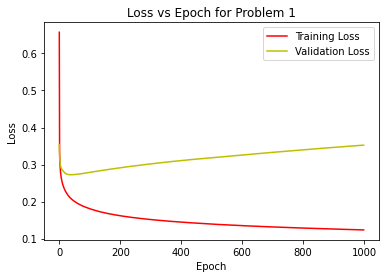

In [56]:
#plotting graph of training loss vs epoch
from matplotlib import pyplot as plt 

x = np.arange(len(loss_graph))
plt.plot(x,loss_graph,'r')
plt.plot(x,val_loss_graph,'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch for Problem 1")
plt.legend(["Training Loss","Validation Loss"])